Objective:

The goal of this notebook is to explore LendingClub loan data using SQL-style queries to understand how credit risk is distributed across borrower segments and how loan pricing (interest rates) varies in relation to that risk.

This exploratory analysis focuses on:
    
    -Understanding the structure and key fields of the dataset relevant to loan performance and pricing

    -Analyzing how loan outcomes (e.g., Fully Paid vs Charged Off) are concentrated across borrower grades, interest rate tiers, and loan amounts

    -Examining early indicators of credit risk and how they relate to pricing decisions in consumer lending

The findings from this analysis will inform which borrower segments, risk factors, and pricing dynamics warrant deeper analysis and will guide business-focused insights and recommendations later in the project.

Question 1: How is credit risk concentrated across borrower grades?

From a lending perspective, borrower grade is a core decision variable used to price loans and manage portfolio risk.

Understanding how loan outcomes vary across grades helps identify where credit risk is most concentrated and whether losses are evenly distributed across the portfolio.

In [7]:
import pandas as pd

# Load raw LendingClub data
df = pd.read_csv("../data/raw/lending_club_loans.csv")

# Keep only relevant loan outcomes
df_filtered = df[df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()

# Create binary default flag
df_filtered["is_default"] = df_filtered["loan_status"].apply(
    lambda x: 1 if x == "Charged Off" else 0
)

# SQL-style aggregation by borrower grade
risk_by_grade = (
    df_filtered
    .groupby("grade")
    .agg(
        total_loans=("loan_status", "count"),
        charge_offs=("is_default", "sum"),
        charge_off_rate=("is_default", "mean"),
        avg_interest_rate=("int_rate", "mean"),
        avg_loan_amount=("loan_amnt", "mean")
    )
    .reset_index()
    .sort_values("grade")
)

risk_by_grade


,grade,total_loans,charge_offs,charge_off_rate,avg_interest_rate,avg_loan_amount
0,A,64187,4036,0.062879,7.392854,13294.734526
1,B,116018,14587,0.125730,11.223131,12895.710795
2,C,105987,22449,0.211809,14.317992,13761.337004
3,D,63524,18338,0.288678,17.484528,14695.402919
4,E,31488,11765,0.373634,20.283007,17723.595497
5,F,11772,5037,0.427880,23.701144,19211.506116
6,G,3054,1461,0.478389,25.904352,20879.952521


Several clear patterns emerge from this aggregation:

- Charge-off rates increase steadily from Grade A through Grade G, indicating that credit risk is highly concentrated in lower borrower grades.
- Average interest rates rise consistently as borrower grade worsens, suggesting that LendingClub prices loans according to perceived credit risk.
- However, the increase in charge-off rates appears steeper than the increase in interest rates at lower grades, raising questions about whether pricing fully compensates for elevated risk.

These findings suggest that borrower grade is a strong driver of both credit risk and loan pricing and motivate a deeper examination of pricing effectiveness across risk tiers.





Question 2: Do higher interest rates sufficiently compensate for higher credit risk?

From a lender’s perspective, interest rates are intended to compensate for expected credit
losses due to borrower default.

In this section, we examine the relationship between interest rates and charge-off risk
across borrower grades to assess whether loan pricing appears proportionate to credit risk.





In [8]:
# Create a comparison table of pricing vs risk
pricing_vs_risk = risk_by_grade.copy()

# Rename for clarity in interpretation
pricing_vs_risk = pricing_vs_risk.rename(columns={
    "charge_off_rate": "charge_off_rate_pct",
    "avg_interest_rate": "avg_interest_rate_pct"
})

# Convert to percentages for readability
pricing_vs_risk["charge_off_rate_pct"] = pricing_vs_risk["charge_off_rate_pct"] * 100

pricing_vs_risk[
    ["grade", "charge_off_rate_pct", "avg_interest_rate_pct"]
]


,grade,charge_off_rate_pct,avg_interest_rate_pct
0,A,6.287878,7.392854
1,B,12.573049,11.223131
2,C,21.180900,14.317992
3,D,28.867829,17.484528
4,E,37.363440,20.283007
5,F,42.787971,23.701144
6,G,47.838900,25.904352


Interpretation: Interest Rates vs Credit Risk

- Interest rates increase steadily across borrower grades, indicating that LendingClub
  prices loans based on perceived credit risk.
- However, charge-off rates rise much more sharply than interest rates at lower grades,
  suggesting that pricing does not scale proportionally with risk.
- This pattern implies that lower-grade loans may carry significantly higher downside
  risk without a commensurate increase in expected return, motivating deeper analysis
  into expected losses and portfolio exposure.


Question 3: Where is the credit risk most concentrated across the portfolio?

While lower borrower grades exhibit higher charge-off rates, portfolio risk is driven by both
default frequency and loan volume. In this section, we analyze how charge-offs are distributed
across borrower grades to identify which segments contribute most to total realized losses.


In [9]:
# Analyze concentration of charge-offs across borrower grades

risk_concentration = (
    df_filtered
    .groupby("grade")
    .agg(
        total_loans=("loan_status", "count"),
        total_charge_offs=("is_default", "sum")
    )
    .reset_index()
)

# Calculate share of total charge-offs

total_charge_offs = risk_concentration["total_charge_offs"].sum()
risk_concentration["charge_off_share_pct"] = (
    risk_concentration["total_charge_offs"] / total_charge_offs * 100
)

# Sort by contribution to total losses

risk_concentration = risk_concentration.sort_values(
    "charge_off_share_pct", ascending=False
)

risk_concentration


,grade,total_loans,total_charge_offs,charge_off_share_pct
2,C,105987,22449,28.901935
3,D,63524,18338,23.609234
1,B,116018,14587,18.780014
4,E,31488,11765,15.146834
5,F,11772,5037,6.484879
0,A,64187,4036,5.196143
6,G,3054,1461,1.880962


Interpretation: Risk Concentration Across Borrower Grades

Although lower-grade loans have higher charge-off rates, total portfolio losses are often
concentrated in mid-grade segments due to higher loan volume.

This indicates that overall credit risk exposure is driven not only by borrower riskiness,
but also by allocation decisions across grades. From a portfolio management perspective,
this suggests that adjusting pricing in high-volume mid-grade segments may have a greater impact on reducing total losses than focusing solely on the riskiest loans.


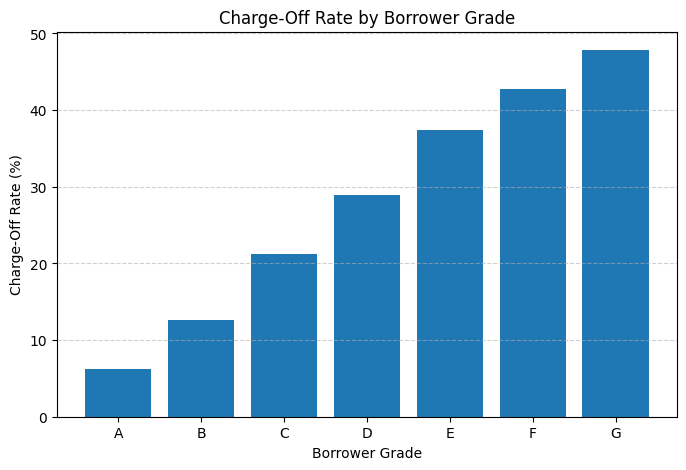

In [10]:
import matplotlib.pyplot as plt

# Prepare data for plotting
plot_df = risk_by_grade.copy()

# Convert charge-off rate to percentage
plot_df["charge_off_rate_pct"] = plot_df["charge_off_rate"] * 100

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(
    plot_df["grade"],
    plot_df["charge_off_rate_pct"]
)

# Labels and title
plt.title("Charge-Off Rate by Borrower Grade")
plt.xlabel("Borrower Grade")
plt.ylabel("Charge-Off Rate (%)")

# Improve readability
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

Interpretation: Charge-Off Rates by Borrower Grade

Charge-off rates increase consistently as borrower grades decline from A to G, indicating a strong and systematic relationship between LendingClub’s credit grading and realized default risk. This visualization confirms that lower borrower grades carry substantially higher downside risk, validating the use of grade as a primary segmentation variable for pricing and portfolio analysis.

In [11]:
import os

os.makedirs("../data/processed", exist_ok=True)

In [12]:
risk_by_grade.to_csv("../data/processed/risk_by_grade.csv", index=False)
pricing_vs_risk.to_csv("../data/processed/pricing_vs_risk.csv", index=False)
risk_concentration.to_csv("../data/processed/risk_concentration.csv", index=False)

# Export Cleaned Datasets for Visualization